In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/intern/katunda_dataset/leaves_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3274 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Leaves_Brownspot', 'Leaves_Healthy', 'Leaves_Woodiness']

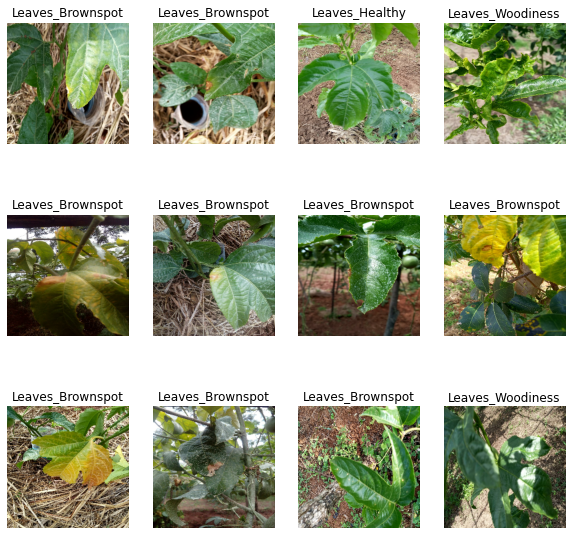

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

82
10
11


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
82/82 [==============================] - 374s 76ms/step - loss: 0.9982 - accuracy: 0.4431 - val_loss: 0.7830 - val_accuracy: 0.5576
Epoch 2/50
82/82 [==============================] - 6s 70ms/step - loss: 0.7333 - accuracy: 0.6345 - val_loss: 0.5886 - val_accuracy: 0.7571
Epoch 3/50
82/82 [==============================] - 6s 71ms/step - loss: 0.5437 - accuracy: 0.7852 - val_loss: 0.5339 - val_accuracy: 0.7790
Epoch 4/50
82/82 [==============================] - 6s 71ms/step - loss: 0.4392 - accuracy: 0.8282 - val_loss: 0.3795 - val_accuracy: 0.8420
Epoch 5/50
82/82 [==============================] - 6s 70ms/step - loss: 0.4168 - accuracy: 0.8417 - val_loss: 0.5271 - val_accuracy: 0.7967
Epoch 6/50
82/82 [==============================] - 6s 70ms/step - loss: 0.3853 - accuracy: 0.8520 - val_loss: 0.3331 - val_accuracy: 0.8593
Epoch 7/50
82/82 [==============================] - 6s 71ms/step - loss: 0.3906 - accuracy: 0.8467 - val_loss: 0.3483 - val_accuracy: 0.8563
Epoch 8/50


In [17]:
scores = model.evaluate(test_ds)

82/82 [==============================] - 2s 21ms/step - loss: 0.0404 - accuracy: 0.9881


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

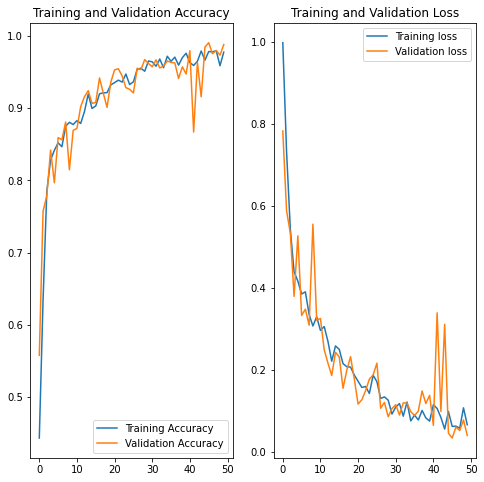

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
import os
os.chdir('/content/drive/MyDrive/intern')

In [21]:
model.save("saved_models/leaves_classification_model")

INFO:tensorflow:Assets written to: saved_models/leaves_classification_model/assets


In [22]:
model.save("saved_models/leaves_classification_model.h5")

first image to predict
actual label: Leaves_Brownspot
[9.9606663e-01 2.9864805e-03 9.4694237e-04]
0
predicted label: Leaves_Brownspot


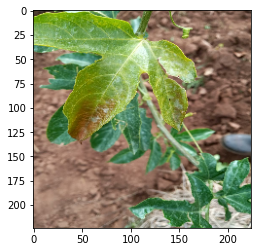

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

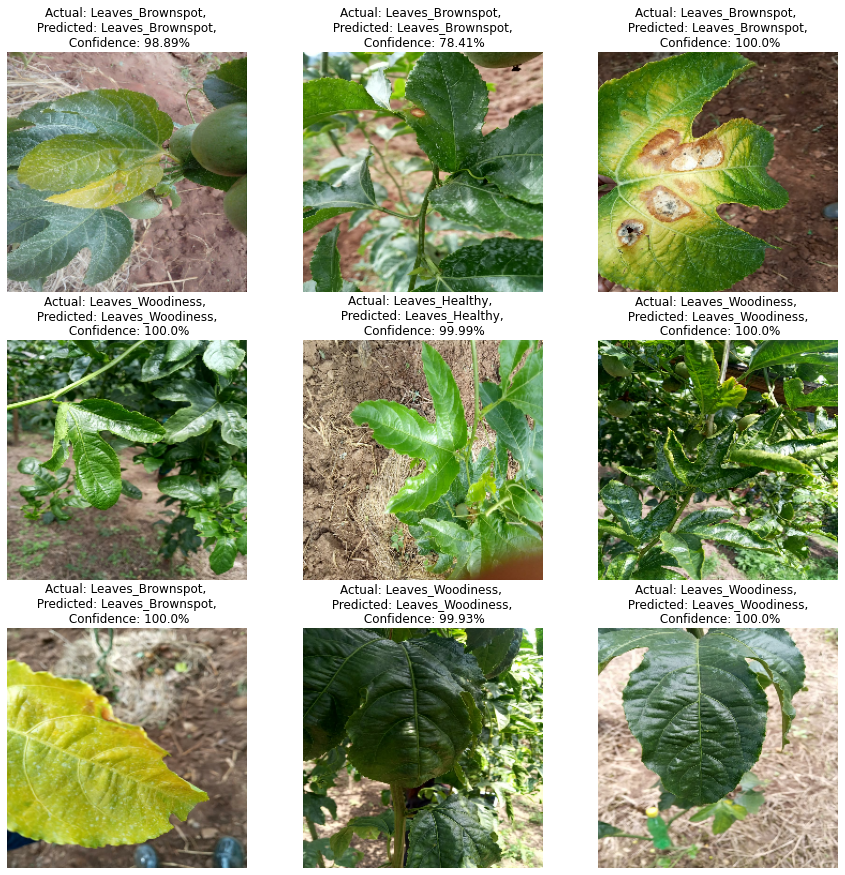

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [26]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as pyplot

In [27]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=pyplot.cm.Blues
):
    
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, "{:0.2f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [28]:
target_names = ["brown_spot", "healthy", "woodiness"]

In [29]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [30]:
print("Confusion Matrix")
conf_matrix = confusion_matrix(correct_labels, predicted_labels)
print(conf_matrix)

Confusion Matrix
[[821   4   5]
 [  1 809   0]
 [  5  16 941]]


Confusion matrix, without normalization
[[821   4   5]
 [  1 809   0]
 [  5  16 941]]


<function matplotlib.pyplot.show>

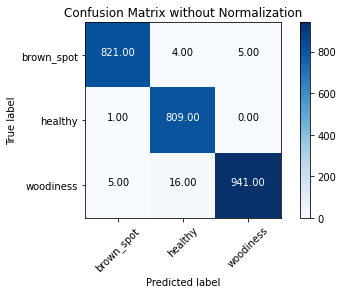

In [31]:
pyplot.figure(1)
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=False, title="Confusion Matrix without Normalization")
pyplot.show

In [32]:
print(classification_report(correct_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

  brown_spot       0.99      0.99      0.99       830
     healthy       0.98      1.00      0.99       810
   woodiness       0.99      0.98      0.99       962

    accuracy                           0.99      2602
   macro avg       0.99      0.99      0.99      2602
weighted avg       0.99      0.99      0.99      2602

